In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
from google.colab import drive
drive.mount('/content/drive')
current_path = rf"/content/drive/My Drive/ProjectX/mini_projects/optimized_mnist"

Mounted at /content/drive


In [16]:
class NN:
  def __init__(self,layer_dims,keep_probs=None):
    self.layer_dims = layer_dims
    self.parameters = None
    self.v = None
    self.s = None
    self.initialize_parameters()
    self.initialize_adams()
    self.t = 0
    self.all_costs = []
    self.beta1 = 0.9
    self.beta2 = 0.999
    self.epsilon = 1e-8
    self.lambd = 0.7
    if(keep_probs == None):
      self.keep_probs = [1.]*len(self.layer_dims)
    else :
      self.keep_probs = keep_probs

  def initialize_parameters(self):
    self.parameters = {}
    L = len(self.layer_dims)
    for i in range(1,L):
      self.parameters["W" + str(i)] = np.random.randn(self.layer_dims[i],self.layer_dims[i-1]) * np.sqrt(2 / self.layer_dims[i-1])
      self.parameters["b" + str(i)] = np.zeros((self.layer_dims[i],1))

  def initialize_adams(self):
    L = len(self.layer_dims)
    self.v = {}
    self.s = {}
    for i in range(1,L):
      self.v["dW" + str(i)] = np.zeros((self.layer_dims[i],self.layer_dims[i-1]))
      self.v["db" + str(i)] = np.zeros((self.layer_dims[i],1))
      self.s["dW" + str(i)] = np.zeros((self.layer_dims[i],self.layer_dims[i-1]))
      self.s["db" + str(i)] = np.zeros((self.layer_dims[i],1))

  def relu(self,Z):
    return np.maximum(0,Z)

  def relu_back(self,Z):
    return (Z > 0).astype(Z.dtype)

  def softmax(self,Z):
    Z_safe = np.clip(Z,-100,100)
    Z_exp = np.exp(Z_safe)
    return Z_exp / np.sum(Z_exp,axis=0,keepdims=True)

  def compute_cost(self,AL,Y):
    m = Y.shape[1]
    safe_AL = np.clip(AL,1e-10,1 - 1e-10)
    cost = (-1/m) * np.sum(Y * np.log(safe_AL))
    cost = np.squeeze(cost)

    L = len(self.layer_dims)
    L2_cost = 0
    for i in range(1,L):
      W = self.parameters["W" + str(i)]
      L2_cost += np.sum(np.square(W))
    L2_cost *= (self.lambd / (2*m))

    cost += np.squeeze(L2_cost)
    return cost

  def forward_prop(self,X):
    caches = []
    L = len(self.layer_dims)
    A_prev = X
    for i in range(1,L-1):
      W = self.parameters["W" + str(i)]
      b = self.parameters["b" + str(i)]
      Z = (W @ A_prev) + b
      A = self.relu(Z)

      kp = self.keep_probs[i]
      D = np.random.rand(A.shape[0],A.shape[1])
      D = (D <= kp).astype('int')
      A = A * D
      A = A / kp

      caches.append((A_prev,W,Z,D))
      A_prev = A

    W = self.parameters["W" + str(L-1)]
    b = self.parameters["b" + str(L-1)]
    Z = (W @ A_prev) + b
    AL = self.softmax(Z)
    caches.append((A_prev,W,Z))
    return AL,caches

  def backward_prop(self,AL,Y,caches):
    m = Y.shape[1]
    L = len(self.layer_dims)
    grads = {}

    A_prev,W,Z = caches[L-2]
    dZL = AL - Y
    WL = self.parameters["W" + str(L-1)]
    dWL = (1 / m) * (dZL @ A_prev.T) + ((self.lambd/m) * WL)
    dbL = (1 / m) * np.sum(dZL,axis=1,keepdims=True)
    dA_prev = W.T @ dZL
    grads["dW" + str(L-1)] = dWL
    grads["db" + str(L-1)] = dbL

    for i in reversed(range(1,L-1)):
      A_prev,W,Z,D = caches[i-1]
      kp = self.keep_probs[i]
      dA_prev = dA_prev * D
      dA_prev =  dA_prev / kp
      dZ = dA_prev * self.relu_back(Z)
      W = self.parameters["W" + str(i)]
      dW = (1/m) * (dZ @ A_prev.T) + + ((self.lambd/m) * W)
      db = (1/m) * np.sum(dZ,axis=1,keepdims=True)
      dA_prev = W.T @ dZ
      grads["dW" + str(i)] = dW
      grads["db" + str(i)] = db

    return grads

  def update_parameters(self,grads,lr):
    L = len(self.layer_dims)
    for i in range(1,L):
      self.parameters["W" + str(i)] -= lr * grads["dW" + str(i)]
      self.parameters["b" + str(i)] -= lr * grads["db" + str(i)]

  def train(self,X,Y,learning_rate=0.07,num_iterations=1000,print_cost=True,adams=False):
    costs = []
    for i in range(num_iterations):
      AL,caches = self.forward_prop(X)
      cost  = self.compute_cost(AL,Y)
      grads = self.backward_prop(AL,Y,caches)

      if adams:
        self.t += 1
        self.update_parameters_with_adams(grads,learning_rate,self.t)
      else:
        self.update_parameters(grads,learning_rate)

      if print_cost and i % 100 == 0:
        print(f"Cost after {i} iterations : {cost}")
      if i % 10 == 0:
        costs.append(cost)
        self.all_costs.append(cost)
        self.store_params()
        self.store_costs()
    print(f"Final cost : {cost}")
    return costs

  def train_mini_batches(self,X,Y,mb_size=64,learning_rate=0.07,num_epochs=1000,print_cost=True,adams=False):
    m = Y.shape[1]
    costs = []
    for i in range(num_epochs):
      tot_cost = 0
      mini_batches = self.random_mini_batches(X,Y,mb_size)
      for mini_batch in mini_batches:
        mini_X,mini_Y = mini_batch
        AL,caches = self.forward_prop(mini_X)
        cost  = self.compute_cost(AL,mini_Y)
        grads = self.backward_prop(AL,mini_Y,caches)
        tot_cost += cost * mini_Y.shape[1]
        if adams:
          self.t += 1
          self.update_parameters_with_adams(grads,learning_rate,self.t)
        else:
          self.update_parameters(grads,learning_rate)

      cost_avg = tot_cost / m
      if print_cost and i % 50 == 0:
        print(f"Cost after {i} epochs : {cost_avg}")
      if i % 10 == 0:
        costs.append(cost_avg)
        self.all_costs.append(cost_avg)
        self.store_params()
        self.store_costs()
    print(f"Final cost : {cost_avg}")
    return costs

  def predict(self,X):
    AL,_ = self.forward_prop(X)
    return self.hardmax(AL)

  def hardmax(self,A):
    maxA = np.max(A,axis=0).reshape(1,A.shape[1])
    return (A >= maxA).astype('float')

  def getAccuracy(self,Y_pred,Y_test):
    pred_classes = np.argmax(Y_pred, axis=0)
    true_classes = np.argmax(Y_test, axis=0)
    return np.mean(pred_classes == true_classes)

  def plot_costs(self,costs):
    plt.figure(figsize=(8,6))
    plt.plot(costs)
    plt.title('Cost Function over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.show()

  def store_params(self):
    params_copy = {}
    for key in self.parameters:
      params_copy[key] = self.parameters[key].tolist()
    with open(f"{current_path}/params.json",'w') as outfile:
      json.dump(params_copy,outfile)

  def store_costs(self):
    with open(f"{current_path}/costs.json",'w') as outfile:
      json.dump(self.all_costs,outfile)

  def random_mini_batches(self,X,Y,mb_size):
    m = Y.shape[1]
    mini_batches = []
    k = mb_size
    perm = list(np.random.permutation(m))
    shuf_X = X[:, perm]
    shuf_Y = Y[:, perm]
    for i in range(m//k):
      mini_X = shuf_X[:,i*k:(i+1)*k]
      mini_Y = shuf_Y[:,i*k:(i+1)*k]
      mini_batches.append((mini_X,mini_Y))
    if m % k != 0:
      mini_X = shuf_X[:,(m//k)*k::]
      mini_Y = shuf_Y[:,(m//k)*k::]
      mini_batches.append((mini_X,mini_Y))
    return mini_batches

  def update_parameters_with_adams(self,grads,lr,t):
    B1 = self.beta1
    B2 = self.beta2
    ep = self.epsilon
    L = len(self.layer_dims)
    for i in range(1,L):
      dW = grads["dW" + str(i)]
      db = grads["db" + str(i)]
      self.v["dW" + str(i)] = B1 * self.v["dW" + str(i)] + (1 - B1) * dW
      self.v["db" + str(i)] = B1 * self.v["db" + str(i)] + (1 - B1) * db
      self.s["dW" + str(i)] = B2 * self.s["dW" + str(i)] + (1 - B2) * np.power(dW,2)
      self.s["db" + str(i)] = B2 * self.s["db" + str(i)] + (1 - B2) * np.power(db,2)

      v_dW = self.v["dW" + str(i)] / (1 - B1**t)
      v_db = self.v["db" + str(i)] / (1 - B1**t)
      s_dW = self.s["dW" + str(i)] / (1 - B2**t)
      s_db = self.s["db" + str(i)] / (1 - B2**t)

      self.parameters["W" + str(i)] -= lr * (v_dW / (np.sqrt(s_dW) + ep))
      self.parameters["b" + str(i)] -= lr * (v_db / (np.sqrt(s_db) + ep))

In [4]:
from keras.datasets import mnist
(train_X, train_y), (test_X, test_y) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [6]:
m_train = train_X.shape[0]
m_test = test_X.shape[0]
print(f"Training examples : {m_train}")
print(f"Testing examples : {m_test}")

Training examples : 60000
Testing examples : 10000


In [7]:
train_X_flatten = train_X.reshape(m_train,-1).T
test_X_flatten = test_X.reshape(m_test,-1).T

train_X_final = train_X_flatten / 255.
test_X_final = test_X_flatten / 255.

In [8]:
train_Y_final = np.zeros((10,m_train),dtype='float')
test_Y_final = np.zeros((10,m_test),dtype='float')

for i in range(train_y.shape[0]):
  train_Y_final[train_y[i]][i] = 1.
for i in range(test_y.shape[0]):
  test_Y_final[test_y[i]][i] = 1.

In [9]:
for i in range(5):
  print(f"{train_y[i]} : {train_Y_final[:,i]}")

5 : [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
0 : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
4 : [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
1 : [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
9 : [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [10]:
print(f"X_train shape : {train_X_final.shape}")
print(f"Y_train shape : {train_Y_final.shape}")
print(f"X_test shape : {test_X_final.shape}")
print(f"Y_test shape : {test_Y_final.shape}")


X_train shape : (784, 60000)
Y_train shape : (10, 60000)
X_test shape : (784, 10000)
Y_test shape : (10, 10000)


In [17]:
layer_dims = [train_X_final.shape[0],128,64,10]
keep_probs = [1.,0.86,0.86,1.]
model = NN(layer_dims,keep_probs)

In [21]:
model.train_mini_batches(train_X_final,train_Y_final,512,0.0001,num_epochs=20,adams=True)
Y_pred_train = model.predict(train_X_final)
Y_pred_test = model.predict(test_X_final)
print(f"Train Accuracy : {model.getAccuracy(Y_pred_train,train_Y_final)}")
print(f"Test Accuracy : {model.getAccuracy(Y_pred_test,test_Y_final)}")

Cost after 0 epochs : 0.18855963236895484
Final cost : 0.1838054302022548
Train Accuracy : 0.9769833333333333
Test Accuracy : 0.9718


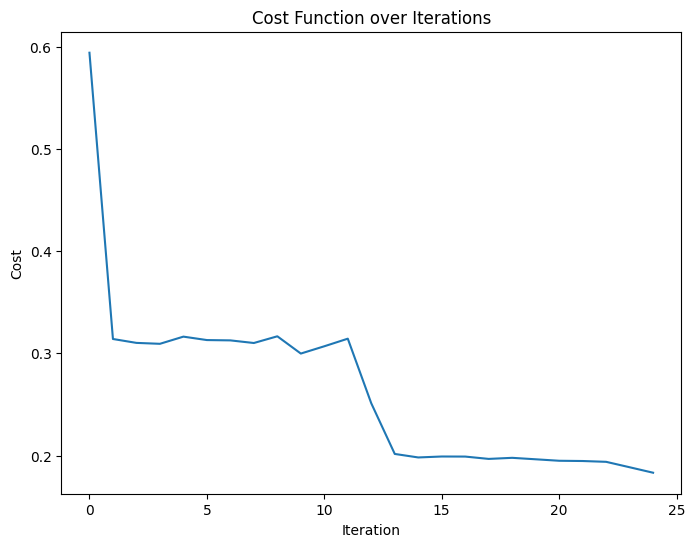

In [22]:
model.plot_costs(model.all_costs)

Index : 4472
True value : 5
Predicted value : 5


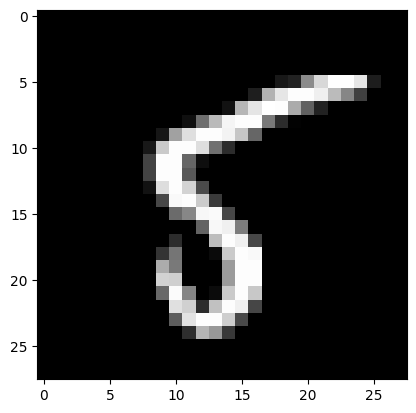

In [24]:
index = np.random.randint(0,m_test)
print(f"Index : {index}")
print(f"True value : {test_y[index]}")
prediction_arr = model.predict(np.array([test_X_final[:,index]]).T)
prediction = np.argmax(prediction_arr)
print(f"Predicted value : {prediction}")
plt.imshow(test_X[index],cmap=plt.get_cmap('gray'))
plt.show()